<font size="5">Get the relative locations between markers</font>


In [179]:
import cv2
import numpy as np

def detect_aruco_corners(img_paths, aruco_type):
    ARUCO_DICT = {
        "DICT_4X4_50": cv2.aruco.DICT_4X4_50,
        "DICT_4X4_100": cv2.aruco.DICT_4X4_100,
        "DICT_4X4_250": cv2.aruco.DICT_4X4_250,
        "DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
        "DICT_5X5_50": cv2.aruco.DICT_5X5_50,
        "DICT_5X5_100": cv2.aruco.DICT_5X5_100,
        "DICT_5X5_250": cv2.aruco.DICT_5X5_250,
        "DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
        "DICT_6X6_50": cv2.aruco.DICT_6X6_50,
        "DICT_6X6_100": cv2.aruco.DICT_6X6_100,
        "DICT_6X6_250": cv2.aruco.DICT_6X6_250,
        "DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
        "DICT_7X7_50": cv2.aruco.DICT_7X7_50,
        "DICT_7X7_100": cv2.aruco.DICT_7X7_100,
        "DICT_7X7_250": cv2.aruco.DICT_7X7_250,
        "DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
        "DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
        "DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
        "DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
        "DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
        "DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
    }

    all_relative_positions = {}

    for img_path in img_paths:
        print("[INFO] Loading image...")
        image = cv2.imread(img_path)

        if image is None:
            print("[ERROR] Image not found or cannot be loaded.")
            continue

        if image.shape[0] > image.shape[1]:
            # Rotate the image 90 degrees counterclockwise
            image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

        if ARUCO_DICT.get(aruco_type, None) is None:
            print("[INFO] ArUCo tag of '{}' is not supported".format(aruco_type))
            continue

        print("[INFO] Detecting '{}' tags in {}...".format(aruco_type, img_path))
        arucoDict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT[aruco_type])
        arucoParams = cv2.aruco.DetectorParameters()
        (corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)
        
        for i, corner in enumerate(corners):
            marker_corners = corner[0]
            marker_centroid = np.mean(marker_corners, axis=0)

            # Draw marker boundaries
            cv2.polylines(image, [marker_corners.astype(np.int32)], True, (0, 255, 0), 2)
            # Draw marker centroid
            cv2.circle(image, tuple(marker_centroid.astype(int)), 5, (0, 0, 255), -1)
            # Draw marker ID
            cv2.putText(image, f"ID: {ids[i][0]}", tuple(marker_centroid.astype(int) + np.array([0, -10])),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        if ids is not None:
            # Find marker 7
            marker7_index = np.where(ids == 7)[0]
            if len(marker7_index) == 0:
                print("Marker 7 not found in {}.".format(img_path))
                continue

            marker7_index = marker7_index[0]
            marker7_corners = corners[marker7_index][0]
            marker7_centroid = np.mean(marker7_corners, axis=0)

            # Calculate relative positions of other markers based on marker 7
            relative_positions = {}
            for i, corner in enumerate(corners):
                if i != marker7_index:
                    marker_corners = corner[0]
                    marker_centroid = np.mean(marker_corners, axis=0)
                    relative_position = marker_centroid - marker7_centroid
                    relative_positions[ids[i][0]] = relative_position.tolist()  # Convert to list for JSON serialization

            all_relative_positions[img_path] = relative_positions
            
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('on')
            plt.show()

            print("Relative positions based on marker 7 in {}: {}".format(img_path, relative_positions))

        else:
            print("No markers detected in {}.".format(img_path))

    return all_relative_positions

In [180]:
img_paths = ["../Positions/2.jpg", "../Positions/3.jpg"]

In [181]:
aruco_type = "DICT_APRILTAG_36h11"

[INFO] Loading image...
[INFO] Detecting 'DICT_APRILTAG_36h11' tags in ../Positions/2.jpg...


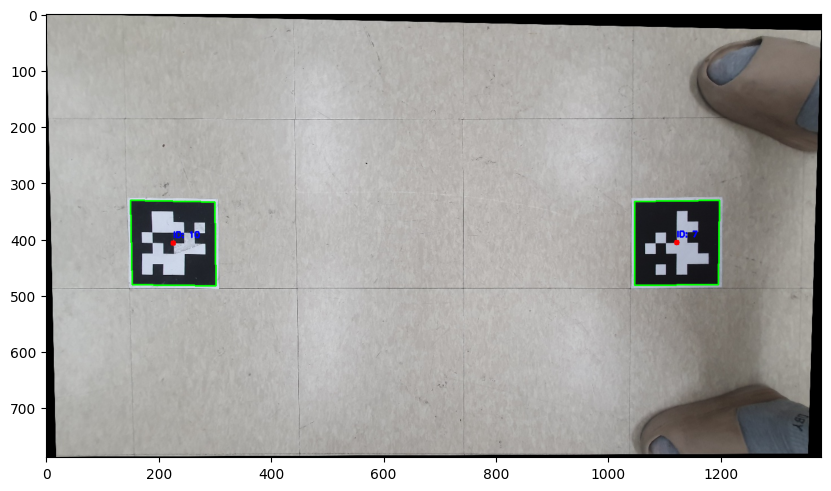

Relative positions based on marker 7 in ../Positions/2.jpg: {10: [-895.75, 0.5]}
[INFO] Loading image...
[INFO] Detecting 'DICT_APRILTAG_36h11' tags in ../Positions/3.jpg...


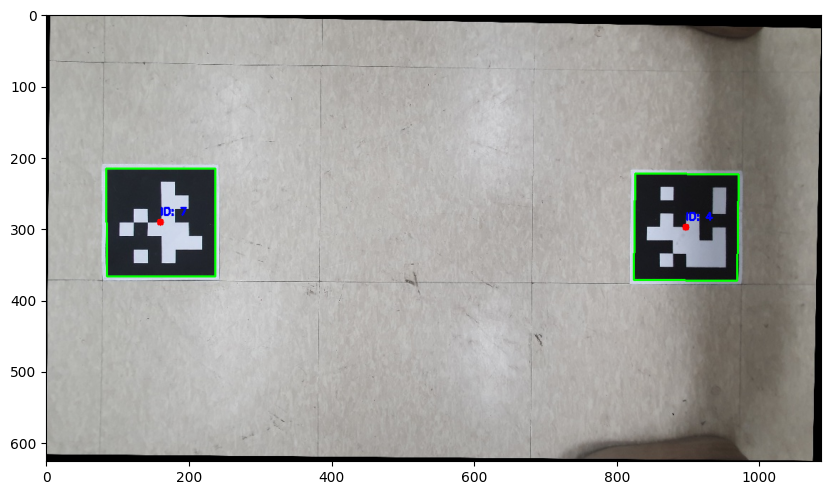

Relative positions based on marker 7 in ../Positions/3.jpg: {4: [736.75, 6.5]}


In [182]:
all_relative_positions = detect_aruco_corners(img_paths, aruco_type)

In [167]:
# Print the first relative coordinate
first_img_path = img_paths[0]
first_relative_position = all_relative_positions.get(first_img_path, None)
if first_relative_position:
    first_relative_coordinate = next(iter(first_relative_position.values()))
    print("First relative coordinate based on Marker 7 in {}: {}".format(first_img_path, first_relative_coordinate))
else:
    print("No relative positions found for {}".format(first_img_path))

First relative coordinate based on Marker 7 in ../Positions/2.jpg: [-895.75, 0.5]


<font size="5">Get the relative locations between shear pocket and markers</font>

In [211]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Locations of boxes
A = (850, 180)
B = (851, 485)
C = (852, 810)
D = (637, 158)
E = (637, 460)
F = (638, 778)

aruco_type = "DICT_APRILTAG_36h11"

def detect_aruco_corners(img_paths, aruco_type):
    ARUCO_DICT = {
        "DICT_4X4_50": cv2.aruco.DICT_4X4_50,
        "DICT_4X4_100": cv2.aruco.DICT_4X4_100,
        "DICT_4X4_250": cv2.aruco.DICT_4X4_250,
        "DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
        "DICT_5X5_50": cv2.aruco.DICT_5X5_50,
        "DICT_5X5_100": cv2.aruco.DICT_5X5_100,
        "DICT_5X5_250": cv2.aruco.DICT_5X5_250,
        "DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
        "DICT_6X6_50": cv2.aruco.DICT_6X6_50,
        "DICT_6X6_100": cv2.aruco.DICT_6X6_100,
        "DICT_6X6_250": cv2.aruco.DICT_6X6_250,
        "DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
        "DICT_7X7_50": cv2.aruco.DICT_7X7_50,
        "DICT_7X7_100": cv2.aruco.DICT_7X7_100,
        "DICT_7X7_250": cv2.aruco.DICT_7X7_250,
        "DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
        "DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
        "DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
        "DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
        "DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
        "DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
    }

    if ARUCO_DICT.get(aruco_type, None) is None:
        print(f"[INFO] ArUCo tag of '{aruco_type}' is not supported")
        return None, None

    arucoDict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT[aruco_type])
    arucoParams = cv2.aruco.DetectorParameters()

    centroids = []
    for img_path in img_paths:
        print(f"[INFO] Loading image {img_path}...")
        image = cv2.imread(img_path)
        if image is None:
            print(f"[ERROR] Image {img_path} not found or cannot be loaded.")
            continue

        if image.shape[0] > image.shape[1]:
            # Rotate the image 90 degrees counterclockwise
            image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

        print(f"[INFO] Detecting '{aruco_type}' tags in {img_path}...")
        corners, ids, _ = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)

        if ids is not None:
            for i, corner in enumerate(corners):
                marker_corners = corner[0]
                marker_centroid = np.mean(marker_corners, axis=0)

                # Draw marker boundaries
                cv2.polylines(image, [marker_corners.astype(np.int32)], True, (0, 255, 0), 2)
                # Draw marker centroid
                cv2.circle(image, tuple(marker_centroid.astype(int)), 5, (0, 0, 255), -1)
                # Draw marker ID
                cv2.putText(image, f"ID: {ids[i][0]}", tuple(marker_centroid.astype(int) + np.array([0, -10])),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # Display the image with detected markers
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(f"Detected ArUco Markers in {img_path}")
            plt.axis('off')
            plt.show()

            marker_centroid = np.mean(marker_corners, axis=0)
            centroids.append((marker_centroid, image, corners, ids))
            print(f"Marker found in {img_path} with centroid at {marker_centroid}.")
        else:
            print(f"No markers detected in {img_path}.")

    return centroids


def calculate_relative_positions(centroids):
    if len(centroids) == 2:
        centroid_1, image_1, corners_1, ids_1 = centroids[0]
        centroid_4, image_4, corners_4, ids_4 = centroids[1]

        # Calculate relative positions for A, B, C based on centroid_1
        A_rel = np.array(A) - centroid_1
        B_rel = np.array(B) - centroid_1
        C_rel = np.array(C) - centroid_1

        # Calculate relative positions for D, E, F based on centroid_4
        D_rel = np.array(D) - centroid_4
        E_rel = np.array(E) - centroid_4
        F_rel = np.array(F) - centroid_4

        return (A_rel, B_rel, C_rel), (D_rel, E_rel, F_rel)
    else:
        print("Could not find markers in both images of img_paths1.")
        return None, None


[INFO] Loading image ../Positions/1.jpg...
[INFO] Detecting 'DICT_APRILTAG_36h11' tags in ../Positions/1.jpg...


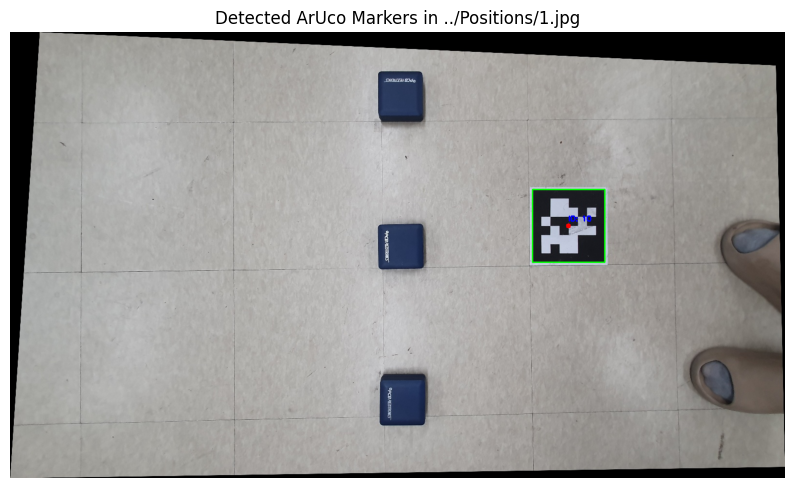

Marker found in ../Positions/1.jpg with centroid at [1151.5  399. ].
[INFO] Loading image ../Positions/4.jpg...
[INFO] Detecting 'DICT_APRILTAG_36h11' tags in ../Positions/4.jpg...


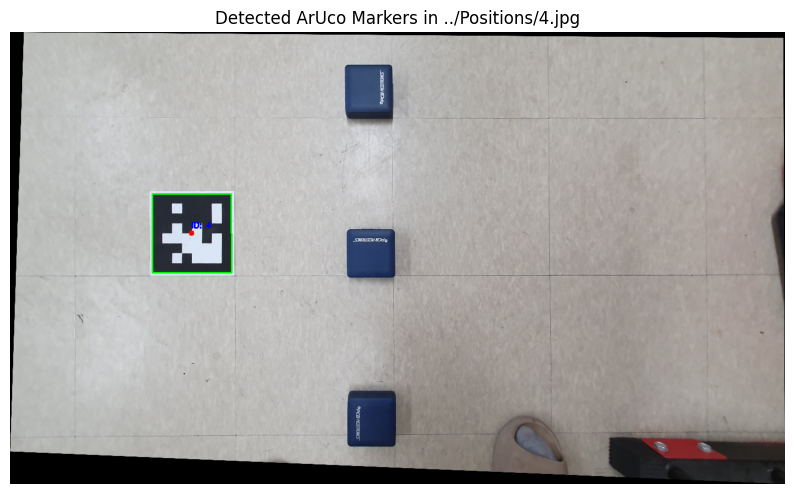

Marker found in ../Positions/4.jpg with centroid at [343.75 380.5 ].
Relative positions based on marker in ../Positions/1.jpg:
A_rel: [-301.5 -219. ]
B_rel: [-300.5   86. ]
C_rel: [-299.5  411. ]
Relative positions based on marker in ../Positions/4.jpg:
D_rel: [ 293.25 -222.5 ]
E_rel: [293.25  79.5 ]
F_rel: [294.25 397.5 ]


In [212]:

img_paths1 = ["../Positions/1.jpg", "../Positions/4.jpg"]

# Detect centroids in the images from img_paths1
centroids1 = detect_aruco_corners(img_paths1, aruco_type)

# Calculate relative positions
rel_positions_1, rel_positions_4 = calculate_relative_positions(centroids1)

if rel_positions_1 and rel_positions_4:
    A_rel, B_rel, C_rel = rel_positions_1
    D_rel, E_rel, F_rel = rel_positions_4

    print(f"Relative positions based on marker in ../Positions/1.jpg:")
    print(f"A_rel: {A_rel}")
    print(f"B_rel: {B_rel}")
    print(f"C_rel: {C_rel}")

    print(f"Relative positions based on marker in ../Positions/4.jpg:")
    print(f"D_rel: {D_rel}")
    print(f"E_rel: {E_rel}")
    print(f"F_rel: {F_rel}")
else:
    print("Error in calculating relative positions.")


<font size="">Get the final coordinates of shear pockets</font>


In [189]:
first_img_path = img_paths[0]
first_relative_position = all_relative_positions.get(first_img_path, None)
if first_relative_position:
    first_relative_coordinate = next(iter(first_relative_position.values()))
    print("First relative coordinate based on Marker 7 in {}: {}".format(first_img_path, first_relative_coordinate))
else:
    print("No relative positions found for {}".format(first_img_path))

First relative coordinate based on Marker 7 in ../Positions/2.jpg: [-895.75, 0.5]


In [190]:
print(first_relative_coordinate)

[-895.75, 0.5]


In [191]:
# Final locations A B C
A_final = A_rel + first_relative_coordinate
B_final = B_rel + first_relative_coordinate
C_final = C_rel + first_relative_coordinate

print("Final Location A:", A_final)
print("Final Location B:", B_final)
print( "Final Location C:",C_final)


Final Location A: [-1197.25  -218.5 ]
Final Location B: [-1196.25    86.5 ]
Final Location C: [-1195.25   411.5 ]


In [192]:
second_img_path = img_paths[1]
second_relative_position = all_relative_positions.get(second_img_path, None)
if second_relative_position:
    second_relative_coordinate = next(iter(second_relative_position.values()))
    print("second relative coordinate based on Marker 7 in {}: {}".format(second_img_path, second_relative_coordinate))
else:
    print("No relative positions found for {}".format(second_img_path))

second relative coordinate based on Marker 7 in ../Positions/3.jpg: [736.75, 6.5]


In [193]:
# Final locations D E F
D_final = D_rel + relative_position
E_final = E_rel + relative_position
F_final = F_rel + relative_position

print("Final Location D:", D_final)
print("Final Location E:", E_final)
print( "Final Location F:",F_final)

Final Location D: [1030. -216.]
Final Location E: [1030.   86.]
Final Location F: [1031.  404.]
